# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1
#! source activate tensorflow

# IF YOU RUN THIS PAGE FOR THE FIRST TIME : 

# START HERE

# OTHERWISE, YOU CAN START BELOW TO AVOID FETCHING ALL THE DATA AGAIN

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from time import time
from sklearn.preprocessing import MinMaxScaler

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [3]:
ROOTPATH = os.getcwd()
path = os.path.join(ROOTPATH, 'Data')

if not os.path.exists(path):
    os.makedirs(path)


# 1) This first part is only accessing in a list all the tickers in our fund, via a csv

In [4]:
# In the file IBB_holdings.csv, the tickers are sorted by descending weigths as of 5-Feb-18
# The file contains a lot of information about the fund IBB as of 5-Feb-18, which can be imported via row[i], i being the column you want
# For now we only import the first column, tickers.

if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
else:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
            
list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")

# 2) We now want to download the data of all tickers as dataframes

In [5]:
# Setting up the variables

start_date = '2016-01-01'
end_date = '2018-01-01'


nb_tickers = len(list_tickers)
list_dataframes=[None]*(nb_tickers)

In [6]:
#On Yahoo
still_missing = nb_tickers
passages = 0

while still_missing > 0 and passages < 100:
    passages += 1
    print("harvest number " , passages)
    for i in range (nb_tickers ):
        if type(list_dataframes[i]) == type(None):   
            symbol = list_tickers[i]
            try:
                df = web.DataReader(symbol, 'yahoo' , start_date ,end_date)
                list_dataframes[i] = df
                still_missing -= 1
            except:
                print("Oops!  That was no valid ticker.  Try again... "+list_tickers[i])

harvest number  1
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... ARRY
Oops!  That was no valid ticker.  Try again... ASND
Oops!  That was no valid ticker.  Try again... ATNX
Oops!  That was no valid ticker.  Try again... BCRX
Oops!  That was no valid ticker.  Try again... BIIB
Oops!  That was no valid ticker.  Try again... BOLD
Oops!  That was no valid ticker.  Try again... CLXT
Oops!  That was no valid ticker.  Try again... COLL
Oops!  That was no valid ticker.  Try again... FOLD
Oops!  That was no valid ticker.  Try again... FPRX
Oops!  That was no valid ticker.  Try again... GLYC
Oops!  That was no valid ticker.  Try again... GTHX
Oops!  That was no valid ticker.  Try again... ICPT
Oops!  That was no valid ticker.  Try again... ILMN
Oops!  That was no valid ticker.  Try again... INVA
Oops!  That was no valid ticker.  Try again... IRWD
Oops!  That was no valid ticker.  Try again...

# 3) Finally, we can download in a new folder all this information for future use, to avoid downloading them from the web again

In [7]:
#Download of the dataframes as as many csv's (for now)

for i in range (nb_tickers ):  
    file_name = 'csv_' + list_tickers[i] + '_from_' + start_date + '_to_' + end_date + ".csv"
    string = path + '\\' + file_name
    list_dataframes[i].to_csv(string , sep=',')

# 4) This program is not (yet) collecting the two tickers that are not equities : BLKFDS and USD

# 5) We also need a benchmark

In [8]:
# Here the benchmark is NASDAQ Biotechnology index 
symbol='^NBI'
benchmark1 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

In [9]:
# Here the benchmark is iShares Nasdaq Biotechnology ETF 
symbol='IBB'
benchmark2 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

# 6) Now we need rate of returns

In [10]:
df_ror_1 = benchmark1['High'].pct_change()
df_ror_2 = benchmark2['High'].pct_change()

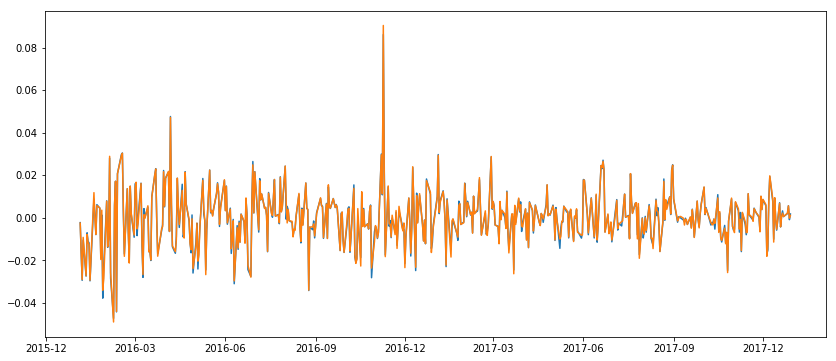

In [11]:
# Both benchmarks should have similar rate of returns, though they have different prices
plt.plot(df_ror_1)
plt.hold
plt.plot(df_ror_2)
plt.show;

In [12]:
def rateOfReturnWeekly(df,column):
    # Column has to be a column of the dataframe (ie 'Open','AdjClose')
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    # So far gives daily as shift = 1!
    shift = 1
    df_shifted = df_sorted.shift(shift)
    rate_of_returns = (df_sorted - df_shifted) / df_shifted
    rate_of_returns = rate_of_returns.drop(rate_of_returns.index[0])

    return rate_of_returns

# 7) Function to add noise to a dataframe (a new dataframe will be created)

In [13]:
def add_noise_2(df_origin, tick, mean = 0, std = 0.005):
    noise = []
    
    # Creating the noise
    for i in range(len(df_origin)):
        x = np.exp(np.random.normal(mean,std))
        noise.append(x)
        
    df_modified = df_origin.copy()
    df_modified['Adj Close'] = df_modified['Adj Close'].multiply(noise)
    
    file_name = 'csv_' + tick + '_B_' + str(mean) + '_' + str(std) + '_from_' + start_date + '_to_' + end_date + '.csv'
    string = path + file_name
    df_modified.to_csv(os.path.join(path,file_name), sep=',') 

# 8) Create all the new csv

In [14]:
"""
allFiles = glob.glob(path + "/csv" + "*.csv")


i=0
if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
    
if computer == 1:    
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
"""

'\nallFiles = glob.glob(path + "/csv" + "*.csv")\n\n\ni=0\nif computer == 0:\n    for file_ in allFiles:\n        with open(file_, \'r\') as csvfile:\n            if list_tickers[i] != \'SNDX\':\n                df = pd.read_csv(csvfile, index_col=None, header=0)\n                add_noise_2(df,list_tickers[i],0,0.01)\n                #add_noise_2(df,list_tickers[i],0,0.008)\n                #add_noise_2(df,list_tickers[i],0,0.0003)\n                #add_noise_2(df,list_tickers[i],0,0.002)\n                #add_noise_2(df,list_tickers[i],0,0.0006)\n            i=i+1\n    \nif computer == 1:    \n    for file_ in allFiles:\n        with open(file_, \'r\', encoding =\'mac_roman\') as csvfile:\n            if list_tickers[i] != \'SNDX\':\n                df = pd.read_csv(csvfile, index_col=None, header=0)\n                add_noise_2(df,list_tickers[i],0,0.01)\n                #add_noise_2(df,list_tickers[i],0,0.008)\n                #add_noise_2(df,list_tickers[i],0,0.0003)\n            

# IF YOU RUN THIS PAGE FOR THE SECOND TIME : 

# START HERE

# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1
#! source activate tensorflow

# 1) Libraries

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# 2) Import

In [3]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

if not(ROOTPATH[-4:] == 'Data'):
    path = os.path.join(ROOTPATH, 'Data')
else:
    path = ROOTPATH

## Import the list of tickers

In [4]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Import the data and convert into arrays

In [5]:
nb_tickers = len(list_tickers)
list_dataframes=[]


allFiles = glob.glob(path + "/csv" + "*.csv")
i = 0

# Fetch the csv data in the directory

if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i+=1

if computer == 1:
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i += 1
            
num_files = i
            
            
maxi = 0
length = 0
compt = 0
j = 0

# Fetch the maximum length of the dfs

for df in list_dataframes:
    if len(df) > maxi:
        maxi = len(df['Adj Close'])

# Initialize the arrays that will stock the stock prices

data = np.array([np.zeros(maxi)]*(num_files))
data_normalized = np.array([np.zeros(maxi)]*(num_files))
tickers_matching = []
# Fill the arrays of the stocks and normalize the data in another array

for i in range(len(list_dataframes)):
    df = list_dataframes[i]
    arr = np.array(df['Adj Close'])
    if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): # Null value of stock breaks the NN
        # Tricky way to get the tickers in the same order as the datas
        tickers_matching.append(''.join(x for x in allFiles[i][115:119] if x.upper()))
        
        data[j] = arr
        minimum = np.min(arr)
        maximum = np.max(arr)
        arr = (arr - minimum) / (maximum - minimum)
        data_normalized[j] = arr
        j += 1
    else :
        compt += 1            
    
# Compt is giving the number of stock that we have filtered during the conversion process above
# At last, compt=29 here
data = data[:-compt]  
data_normalized = data_normalized[:-compt]  


## Create training, validation and testing set

In [6]:
# Shuffle the previous data
idx = np.arange(0 , len(data))
np.random.shuffle(idx)
data_shuffle = [data_normalized[ i] for i in idx]


# Train on approximately 75% of the dataset, validation on 12.5% and test on 12.5%
train_set = data_shuffle[:-50]
test_set = data_shuffle[-50:-25]
validation_set = data_shuffle[-25:]

# 3) Functions

## Initializing functions

In [7]:
def weight_variable(num_input, num_output):
    init = tf.random_normal([num_input, num_output],mean=0.0, stddev=1.0/np.sqrt(num_input))
    return(tf.Variable(init))

def bias_variable(num_output):
    init = tf.zeros([num_output]),
    return(tf.Variable(init))

## Training functions

In [8]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

## Tensorboard functions

In [9]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [10]:
def variable_summary_light(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

## Fetch data functions

In [11]:
def find_ticker_batch(batch, data_norm):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][0] - true[0] == 0:
            index = i
        i += 1
    ticker = tickers_matching[index]
    return(ticker, index)

# 4) Parameters

In [12]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 10
lambd = 0.1

display_step = 100

# Network Parameters 

num_input = 503 # 503 days considered
num_hidden_1 = 250 # 1st layer num features
num_output = num_input

date = str(int(time()))
print(date)
logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

1519146972


# 5) Create NN

## Placeholders

In [13]:
X = tf.placeholder("float", [None, num_input])
learning = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32) #gateway for dropout

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1],mean=0.0,
    stddev=1.0/np.sqrt(num_input))),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    stddev=1.0/np.sqrt(num_hidden_1)))
}
biases = {
    'encoder_b1': tf.Variable(tf.zeros([num_hidden_1])),
    'decoder_b1': tf.Variable(tf.zeros([num_input])),
}

### Building the encoder
def encoder(x, layer_name='encoder'):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_e = weights['encoder_h1']
            variable_summary(weights_e)
        with tf.name_scope('biases'):
            biases_e = biases['encoder_b1']
            variable_summary(biases_e)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.add(tf.matmul(x, weights_e), biases_e)
            tf.summary.histogram('pre_activations', preactivate)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return activations


### Building the decoder
def decoder(x,  layer_name='decoder'):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_d = weights['decoder_h1']
            variable_summary(weights_d)
        with tf.name_scope('biases'):
            biases_d = biases['decoder_b1']
            variable_summary(biases_d)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.add(tf.matmul(x, weights_d), biases_d)
            tf.summary.histogram('pre_activations', preactivate)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return activations

## Building layers

In [14]:
# General way to implement layers with TensorBoard writing

def encoder(input_tensor, input_dim, output_dim, layer_name='encoder'):
    # Just 1 layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_e = weight_variable(input_dim, output_dim)
            variable_summary_light(weights_e)
        with tf.name_scope('biases'):
            biases_e = bias_variable(output_dim)
            variable_summary_light(biases_e)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights_e) + biases_e
            tf.summary.histogram('pre_activations', preactivate)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return(activations, weights_e, biases_e)
    
def bottleneck(input_tensor, input_dim, output_dim, layer_name='bottleneck'):
    # Just 1 layer / return the latent 
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_b = weight_variable(input_dim, output_dim)
            variable_summary_light(weights_b)
        with tf.name_scope('biases'):
            biases_b = bias_variable(output_dim)
            variable_summary_light(biases_b)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights_b) + biases_b
            tf.summary.histogram('pre_activations', preactivate)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return(activations, weights_b, biases_b, preactivate)

def decoder(input_tensor, input_dim, output_dim, layer_name='decoder'):
    # Just 1 layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_d = weight_variable(input_dim, output_dim)
            variable_summary_light(weights_d)
        with tf.name_scope('biases'):
            biases_d = bias_variable(output_dim)
            variable_summary_light(biases_d)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights_d) + biases_d
            tf.summary.histogram('pre_activations', preactivate)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return(activations, weights_d, biases_d)

In [15]:
# Construct model
(encoder_op, weights_b, bias_b, latent) = bottleneck(X, num_input, num_hidden_1)

with tf.name_scope('dropout'):
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(encoder_op, keep_prob)

(decoder_op, weights_d_1, bias_d_1)= decoder(dropped, num_hidden_1, num_output)

## Prediction Step

In [16]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
mse = tf.squared_difference(y_pred, y_true)

## Loss

In [17]:
regularizer = tf.nn.l2_loss(weights_b)
regularizer += tf.nn.l2_loss(weights_d_1)

loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)

#Replace learning_rate by learning to get an adaptative learning rate
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

## Summary events for TensorBoard

In [18]:
# Add the 'loss' event
tf.summary.scalar("loss", loss)

# Add the 'accuracy' event
# tf.summary.scalar("accuracy", acc)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# 6) Training the autoencoder

In [19]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

# Prepare the summary file for TensorBoard
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

dropout = .9

start_time = time()

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    total_batch = int(len(train_set)/batch_size)
    
    for j in range(total_batch):
        mini_batch_x, _ = next_batch(batch_size,train_set,train_set)

        # Run optimization op (backprop) and cost op (to get loss value)
        if i==2000:
            learn = inter_learn
        elif i==4000:
            learn = final_learn

        _, l, summary = sess.run([optimizer, loss, merged_summary_op], 
                    feed_dict={X: mini_batch_x, learning : learn,  keep_prob : dropout})
        costs.append(l)
        
    # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
    summary_writer.add_summary(summary, i)
    
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        curr_time = time()
        elapsed_time = curr_time-start_time
        print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 14.097762
Estimated remaining time =  30.93662929534912 s

Step 100: Minibatch Loss: 0.029546
Estimated remaining time =  13.303734302520754 s

Step 200: Minibatch Loss: 0.033417
Estimated remaining time =  6.367184519767761 s

Step 300: Minibatch Loss: 0.031314
Estimated remaining time =  0.0 s



# 7) Testing the autoencoder

## Test on n batches

In [20]:
# Testing
n = 10

for i in range(n):
    batch_x, _ = next_batch(batch_size,test_set,test_set)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob: 1})
    print('Minibatch Loss: ', l)   

Minibatch Loss:  0.02555535
Minibatch Loss:  0.031010203
Minibatch Loss:  0.028807899
Minibatch Loss:  0.023870215
Minibatch Loss:  0.026240176
Minibatch Loss:  0.025312988
Minibatch Loss:  0.021103423
Minibatch Loss:  0.023644065
Minibatch Loss:  0.030228525
Minibatch Loss:  0.026268454


## Take the full test set for latent plot

test_data_array = np.asarray(test_set)
test_data_tickers = []
for i in range(test_data_array):
    ticker = find_ticker_batch(test_data_array[i], data_normalized)
    test_data_tickers.append(ticker)

pred = sess.run([latent], feed_dict={X: test_data_array, keep_prob: 1})
pred = np.asarray(pred)

test_data_array[1]

# 8) Exporting

In [ ]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

In [ ]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519078121/

# 9) Plotting

In [ ]:
def unnormalize(pred, data):
    minimum = np.min(data)
    maximum = np.max(data)
    
    unnorm = pred * (maximum - minimum) + minimum
    return(unnorm)

In [ ]:
## Plot the predicted values
def plot_predict(batch):
    batch_size = len(batch)
    unnormalized_p = {}
    
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], data_normalized)
        unnormalized_p[j] = unnormalize(p[j], data[j])
    
    for j in unnormalized_p.keys():
        plt.figure()
        plt.plot(unnormalized_p[j] ,'r')
        plt.hold
        plt.plot(data[j] ,'b')
        plt.show;

In [ ]:
plot_predict(batch_x)